# Importación y análisis de datos 🤓 🔍

Aquí encontrarás una guía básica de cómo realizar una exploración de datos. Iniciando con su importación usando pandas hasta realizar análisis gráfico usando seaborn y matplotlib.

### Carga y transformación de datos
`pandas` es una librería de python que te permitirá importar diferentes tipos de archivos tales como .csv, .xlsx, .pkl (formato de almacenamiento de modelos de ml) entre otros... también te será muy útil si necesitas crear o transformar variables. En este caso, importaremos los archivos en formato .csv que Factored ha cargado previamente en un bucket de S3 en Amazon AWS. Luego, calcularemos la matriz de correlaciones de Pearson, analizaremos cada una de las variables disponibles en el dataset y crearemos nuevas columnas usando los métodos exclusivos de `pandas` para trabajar con columnas tipo `timestamp`.

En la [documentación oficial](https://pandas.pydata.org/pandas-docs/dev/index.html) encontrarás toda la información de los métodos disponibles, una introducción a los principales conceptos de la librería y links con tutoriales.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Importamos dataset desde servidor de Factored
#df_train = pd.read_csv("https://factored-workshops.s3.amazonaws.com/taxi-trip-duration.csv")
# Importamos dataset desde local
df_train = pd.read_csv("../datasets/taxi-trip-duration.csv")
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447855 entries, 0 to 1447854
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1447855 non-null  object 
 1   vendor_id           1447855 non-null  int64  
 2   pickup_datetime     1447855 non-null  object 
 3   dropoff_datetime    1447855 non-null  object 
 4   passenger_count     1447855 non-null  int64  
 5   pickup_longitude    1447855 non-null  float64
 6   pickup_latitude     1447855 non-null  float64
 7   dropoff_longitude   1447855 non-null  float64
 8   dropoff_latitude    1447855 non-null  float64
 9   store_and_fwd_flag  1447855 non-null  object 
 10  trip_duration       1447855 non-null  int64  
 11  pickup_borough      1447855 non-null  object 
 12  dropoff_borough     1447855 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 143.6+ MB


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_borough,dropoff_borough
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Manhattan,Manhattan
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Manhattan,Brooklyn
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Manhattan,Brooklyn
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Brooklyn,Brooklyn
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Manhattan,Manhattan


El objetivo de este modelo es predecir el tiempo total del trayecto en taxi, por lo tanto, no podemos incluir en él la variable `dropoff_datetime` dado que estaríamos incluyendo en el modelo una variable con la cual se puede calcular la variable respuesta (`duración del trayecto = pickup_datetime - dropoff_datetime`) y por lo tanto debe ser eliminada. Este escenario es más conocido como [data leakage.](https://www.kaggle.com/alexisbcook/data-leakage)

In [3]:
df_train = df_train.drop("dropoff_datetime", axis=1)

Para revisar el tipo de dato de cada columna del data frame de pandas se puede usar la propiedad `dtypes`.

In [4]:
df_train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
pickup_borough         object
dropoff_borough        object
dtype: object

Como podemos ver, la columna `pickup_datetime` debería tener un formato de fecha. Sin embargo, está como `string`. Usando la función `to_datetime()` podemos convertir la columna a formato de fecha.

In [5]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

Teniendo la columna `pickup_datetime` en formato fecha podemos usar las propiedades que tiene este tipo de dato para extraer el año, mes, día de la semana y hora.

In [6]:
df_train["year"] = df_train["pickup_datetime"].dt.year
df_train["month"] = df_train["pickup_datetime"].dt.month
df_train["weekday"] = df_train["pickup_datetime"].dt.weekday
df_train["hour"] = df_train["pickup_datetime"].dt.hour

df_train[["pickup_datetime","year","month","weekday","hour"]].head()

,pickup_datetime,year,month,weekday,hour
0,2016-03-14 17:24:55,2016,3,0,17
1,2016-06-12 00:43:35,2016,6,6,0
2,2016-01-19 11:35:24,2016,1,1,11
3,2016-04-06 19:32:31,2016,4,2,19
4,2016-03-26 13:30:55,2016,3,5,13


Usando la propiedad `shape` que tienen los data frames de pandas es posible ver su dimensión (# filas, # columnas)

In [7]:
df_train.shape

(1447855, 16)

Una forma rápida de ver las estadísticas descriptivas de las columnas del data frame es usar el método `describe()`.

In [8]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,year,month,weekday,hour
count,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000,1447855.00000
mean,1.53507,1.66538,-73.97361,40.75097,-73.97354,40.75185,843.11907,2016.00000,3.51651,3.04952,13.61218
std,0.49877,1.31472,0.07066,0.03259,0.07040,0.03563,682.37671,0.00000,1.68107,1.95379,6.39659
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,61.00000,2016.00000,1.00000,0.00000,0.00000
25%,1.00000,1.00000,-73.99187,40.73740,-73.99133,40.73594,401.00000,2016.00000,2.00000,1.00000,9.00000
50%,2.00000,1.00000,-73.98177,40.75413,-73.97977,40.75455,665.00000,2016.00000,4.00000,3.00000,14.00000
75%,2.00000,2.00000,-73.96742,40.76836,-73.96310,40.76982,1076.00000,2016.00000,5.00000,5.00000,19.00000
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,35426.00000,2016.00000,6.00000,6.00000,23.00000


De las estadísticas descriptivas podemos concluir los siguientes puntos:
* La cantidad de pasajeros transportados va desde 0 hasta 9
* La duración puede tomar mínimo 1 segundo y máximo 3'526.282 segundos que aproximadamente son 5.938 horas (¿Estos datos tienen sentido?) Es importante revisar si existen datos atípicos.
*Los datos corresponden a los meses entre enero y junio del año 2016

In [9]:
df_train[['id','trip_duration']].sort_values('trip_duration', ascending=False).head(n=10)

,id,trip_duration
1320061,id3019961,35426
1264157,id3815739,35270
1220144,id3747466,35189
872320,id0211213,35022
868880,id3206453,34920
642761,id2456509,34916
524729,id3253229,34014
999809,id3548289,32495
931728,id1745350,32338
1369267,id2954681,32322


Organizando los registros en orden descendente por la variable `trip_duration` nos podemos dar cuenta que hay 5 registros que tienen un valor mayor a 1'900.000 segundos (Aprox. 22 días). Estos registros pueden ser calificados como outliers y por lo tanto pueden ser eliminados.

In [10]:
df_train = df_train[df_train['trip_duration'] < 100000]

**CHECK POINT #1**

Con cuántos registros y columnas queda el data set?

In [11]:
df_train.shape

(1447855, 16)

### Análisis de variables
Para iniciar el análisis de variables se recomienda revisar las distribuciones de las variables, su comportamiento bi-variado y la correlación entre estas.

Para realizar análisis de forma gráfica hay una gran variedad de librerías en Python como `seaborn`, `matplotlib`, `plotly` entre otras. `seaborn` y `matplotlib` son muy similares dado que `seaborn` es una librería basada en `matplotlib` pero con un diseño más sofisticado y más agradable a los ojos del usuario, `plotly` por su lado crea gráficos más dinámicos e interactivos.

In [12]:
#!pip install plotly #ejecutar este comando si no se tiene la librería de plotly instalada
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#### Matriz de correlaciones

<AxesSubplot:>

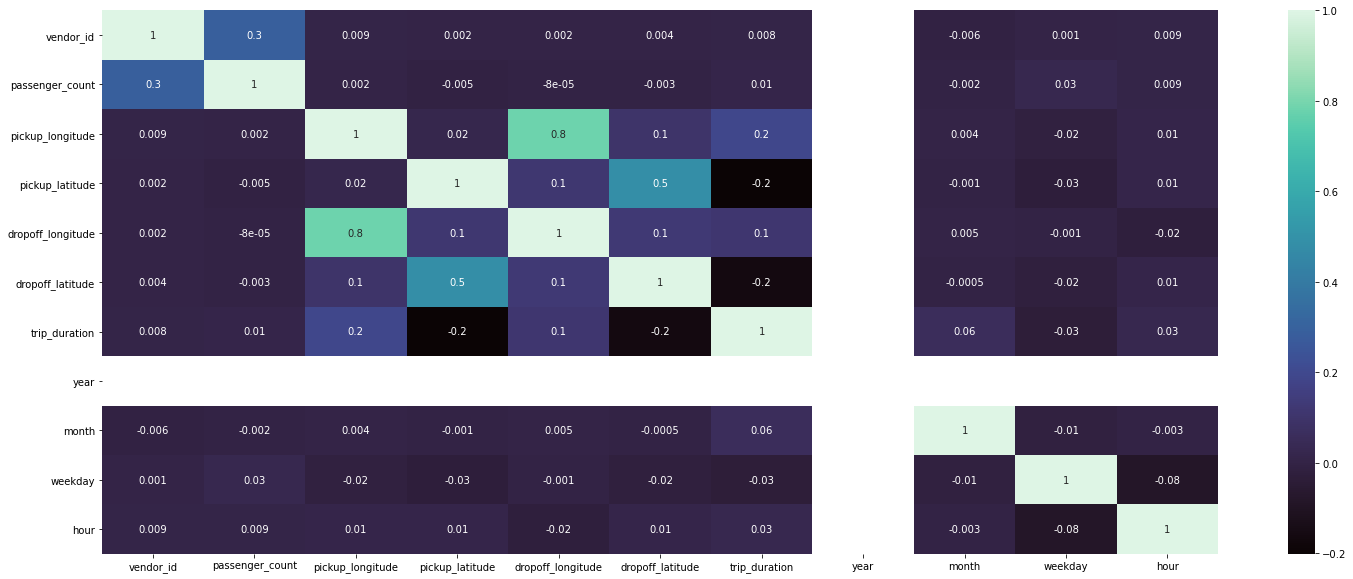

In [13]:
plt.subplots(figsize=(25,10))
sns.heatmap(df_train.corr(), annot=True, fmt='.1g', cmap="mako")

En algunos algoritmos como en la regresión logística es importante **no incluir** dos variables que estén correlacionadas dado que esto afecta los estimadores de los parámetros. Realizar este análisis nos ayudará a entender qué pares de variables están correlacionadas y dependiendo del algoritmo que estemos usando podremos decidir cuál incluir y cuál no. La correlación más usada es la [correlación de Pearson](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson). Sin embargo, también puedes usar la [correlación de spearman](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Spearman) si lo que buscas es evaluar la relación monotónica entre dos variables en lugar de la relación lineal entre ellas. [Este artículo](https://towardsdatascience.com/clearly-explained-pearson-v-s-spearman-correlation-coefficient-ada2f473b8) lo explica a mayor profundidad.

#### Variable respuesta: `trip_duration`
Para revisar la distribución de una variable podemos usar un boxplot dado que nos indicará cuales son los límites de los cuartiles de la variable.

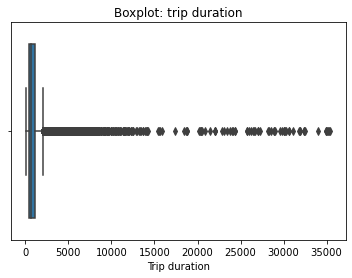

In [14]:
fig, ax = plt.subplots()
sns.boxplot(data = df_train,
            x = "trip_duration",
            ax = ax)
ax.set_title("Boxplot: trip duration")
ax.set_xlabel("Trip duration")

plt.show()

Dado que la variable tiene muchos outliers podemos truncar el rango del eje x de la gráfica para visualizar mejor los cuartiles. Para esto, podemos usar la opción `ax.set_xlim()` de `matplotlib`.

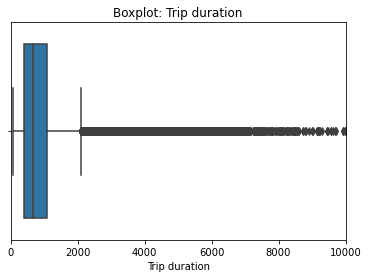

In [15]:
fig, ax = plt.subplots()
sns.boxplot(data = df_train,
            x = "trip_duration",
            ax = ax)
ax.set_xlim(0, 10000)
ax.set_title("Boxplot: Trip duration")
ax.set_xlabel("Trip duration")
plt.show()

Otra versión del boxplot para la variable `trip_duration` usando la librería `plotly`.

In [16]:
'''
fig = px.box(df_train,
             y = "trip_duration",
             labels = {"trip_duration": "Trip duration"},
             title = "Boxplot: Trip duration")
fig.update_yaxes(range=[0, 10000])
fig.show()
'''

'\nfig = px.box(df_train,\n             y = "trip_duration",\n             labels = {"trip_duration": "Trip duration"},\n             title = "Boxplot: Trip duration")\nfig.update_yaxes(range=[0, 10000])\nfig.show()\n'

Luego de ver con diferentes librerías cómo es la distribución de la variable respuesta `trip_duration` podemos concluir que tiene muchos outliers, el promedio de duración de 662seg (es decir, 11 minutos) y el 75% de los viajes duran 1075seg o menos (18min).

#### Vendor Id
Usando `seaborn` podemos realizar una gráfica de dispersión de datos cuando una de las variables es categórica, su nombre es `stripplot`.

Text(0.5, 1.0, 'Vendor Id vs. Trip duration')

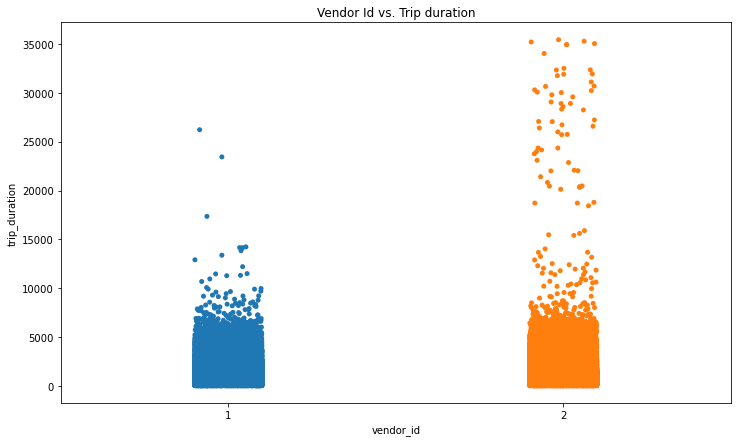

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.stripplot(data = df_train,
              x = "vendor_id",
              y = "trip_duration",
              ax = ax)
ax.set_title("Vendor Id vs. Trip duration")

Podemos ver que la mayoría de viajes del vendedor 1 están en su mayoría por debajo de 10.000 segundos (aprox. 2.7 horas), a diferencia del vendedor 2 donde hay muchos registros donde se supera este límite de tiempo.

#### Month
**CHECK POINT #2**

Cómo se vería un gráfico de dispersión de la duración del viaje en los diferentes meses del año?

Text(0.5, 1.0, 'Months vs. Trip duration')

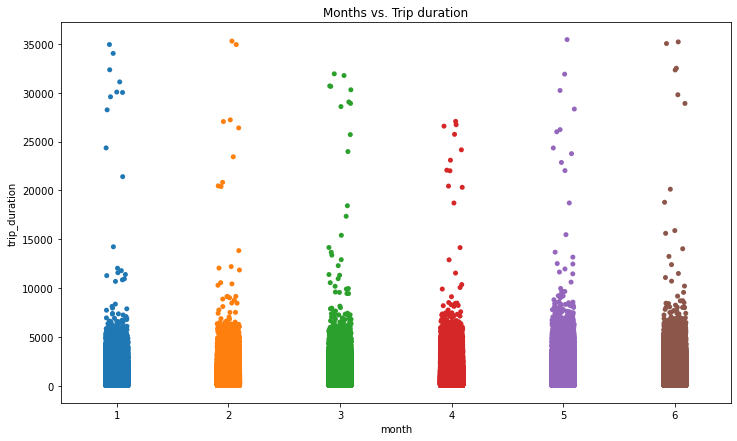

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.stripplot(data = df_train,
              x = "month",
              y = "trip_duration",
              ax = ax)
ax.set_title("Months vs. Trip duration")

Usando los métodos `groupby` y `agg` podrás agregar las columnas y calcular métricas sobre cada agrupación.

In [19]:
df_train[['month', 'trip_duration']].groupby(by=['month']).agg({'trip_duration':['mean', 'count']})

trip_duration        
               mean   count
month                      
1         796.44573  228065
2         795.39202  236600
3         823.72103  254322
4         854.07138  249709
5         890.15561  246619
6         897.02434  232540

En el resultado, podemos ver que alrededor de 230.000 - 240.0000 viajes se hacen por mes y la duración promedio está entre 900 y 1000 segundos (aprox. 15 - 16 min).

#### Hour
Usando los métodos de agregación crearemos un nuevo dataframe de pandas para poder representar estas métricas en gráficos de barra.

Text(0, 0.5, 'Trips')

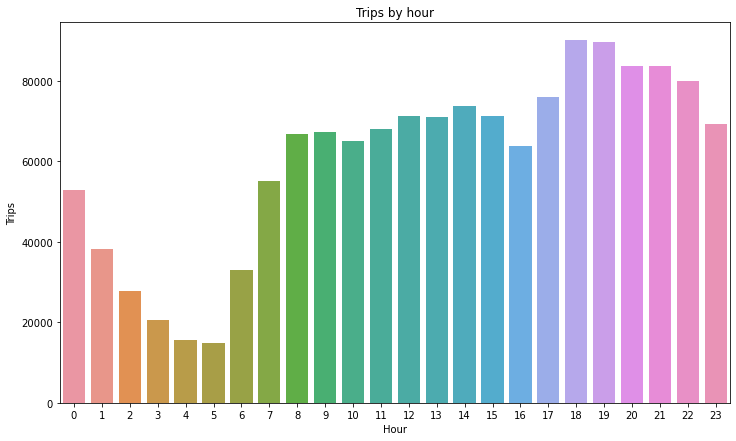

In [20]:
hour_trip = df_train[['hour', 'trip_duration']].groupby(by=['hour']).agg({'trip_duration': 'count'}).reset_index()

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data = hour_trip,
            x = "hour",
            y = "trip_duration",
            ax = ax)
ax.set_title("Trips by hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Trips")

Era de esperarse que los horarios con mayor cantidad de viajes sean al finalizar la jornada laboral (6-7pm). Sin embargo, también podemos revisar el promedio de duración de los viajes dependiendo de la hora en la que inició el servicio.

Text(0, 0.5, 'Avg Trip Duration')

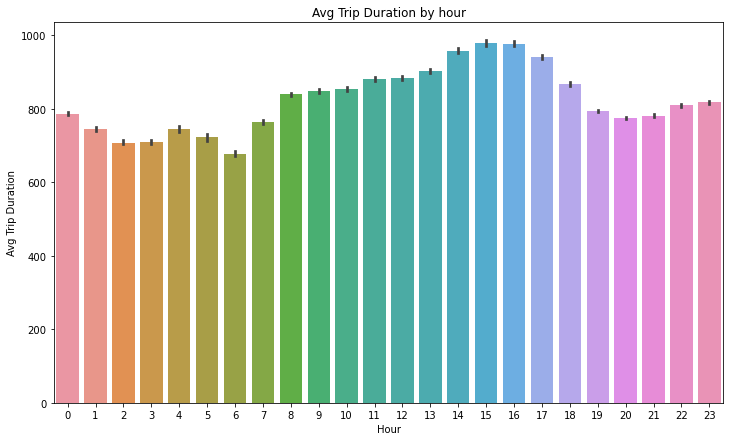

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data = df_train,
            x = "hour",
            y = "trip_duration",
            ax = ax)
ax.set_title("Avg Trip Duration by hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Avg Trip Duration")

Analizando la gráfica podemos ver que el tiempo promedio de viaje varía de acuerdo a la hora de inicio del viaje lo que quiere decir que la hora puede ser una variable interesante para predecir el tiempo de duración del viaje.

#### Weekday

Text(0, 0.5, 'Trips')

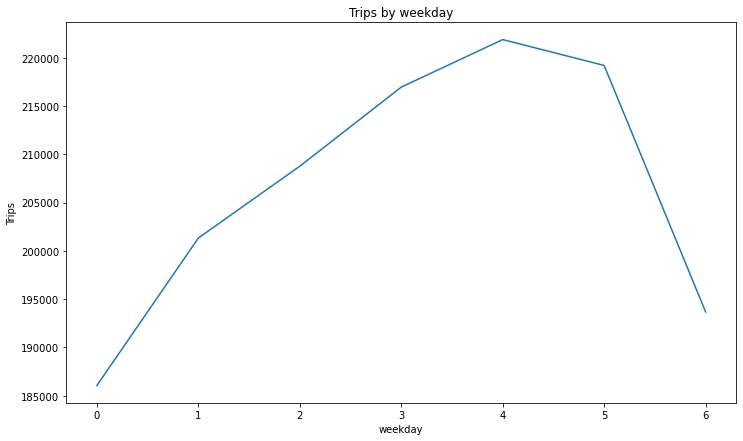

In [22]:
weekday_trip = df_train[['weekday', 'trip_duration']].groupby(by=['weekday']).agg({'trip_duration': 'count'}).reset_index()

fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data = weekday_trip,
             x = "weekday",
             y = "trip_duration",
             ax = ax,
             markers = True)
ax.set_title("Trips by weekday")
ax.set_xlabel("weekday")
ax.set_ylabel("Trips")

Teniendo en cuenta la documentación de `pandas` sobre la función [weekday](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.weekday.html) podemos ver que 0 indica el día lunes y 6 el domingo. Teniendo en cuenta esto, podemos concluir que los días con mayor cantidad de viajes en taxi son los días cercanos al fin de semana, más específicamente entre jueves y sábado.

**CHECK POINT #3**
Grafica un barplot teniendo en cuenta el día de la semana (`weekday`) y el promedio de la duración del viaje (`trip_duration`).¿Qué puedes concluir del resultado? ¿Crees que esta variable es relevante para el modelo predictivo?

Text(0, 0.5, 'Avg Trip Duration')

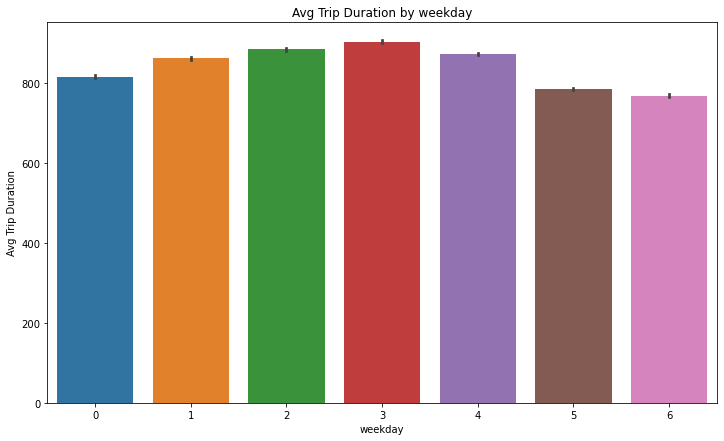

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data = df_train,
            x = "weekday",
            y = "trip_duration",
            ax = ax)
ax.set_title("Avg Trip Duration by weekday")
ax.set_xlabel("weekday")
ax.set_ylabel("Avg Trip Duration")

#### Passengers

In [24]:
passengers_trip = df_train[['passenger_count','trip_duration']].groupby(by=['passenger_count']).agg({'trip_duration':['count','min','max',np.mean]})#.reset_index()
passengers_trip

trip_duration                      
                        count  min    max      mean
passenger_count                                    
0                          17   68   3243 974.64706
1                     1025335   61  35426 831.46356
2                      209112   61  35022 883.29541
3                       59547   61  32495 872.48803
4                       28226   61  10380 892.02406
5                       77583   61  34920 849.98556
6                       48033   61  34916 840.75163
8                           1  104    104 104.00000
9                           1  560    560 560.00000

De la tabla anterior podemos concluir:
* Los viajes de 0 pasajeros tienen la duración media más alta de todos los grupos por cantidad de pasajeros.
* La mayoría de los viajes los realiza una persona.
* La duración media de los viajes son muy similares independientemente si va de 1 a 6 personas.

#### Pickup and dropoff borough
Con `pandas` también podemos hacer tablas dinámicas como las que conocemos de Excel. Para esto, usamos el método `pivot_table` como lo vemos a continuación.

In [25]:
pivot_table = pd.pivot_table(df_train, values='trip_duration', index=['pickup_borough'],
                             columns=['dropoff_borough'], aggfunc=np.mean)
pivot_table

dropoff_borough,Bronx,Brooklyn,Manhattan,Queens,Staten_island
pickup_borough,,,,,
Bronx,630.02091,2257.80000,990.68125,1349.42857,3628.40000
Brooklyn,2104.64354,650.62332,976.51092,1903.21012,2835.20470
Manhattan,1546.77994,1055.14337,646.76543,1758.74042,2740.65887
Queens,1692.97097,2030.90487,1929.40611,936.21525,1670.33264
Staten_island,2531.93363,2538.14616,2872.78659,1468.85976,1261.80725


Dado que en la tabla dinámica estamos comparando la misma métrica de promedio de duración del viaje entre diferentes destinos, podemos usar la gráfica de `heatmap` de `seaborn` para hacer la tabla más amigable con el usuario y de esta forma se pueden sacar conclusiones más rápidas.

<AxesSubplot:xlabel='dropoff_borough', ylabel='pickup_borough'>

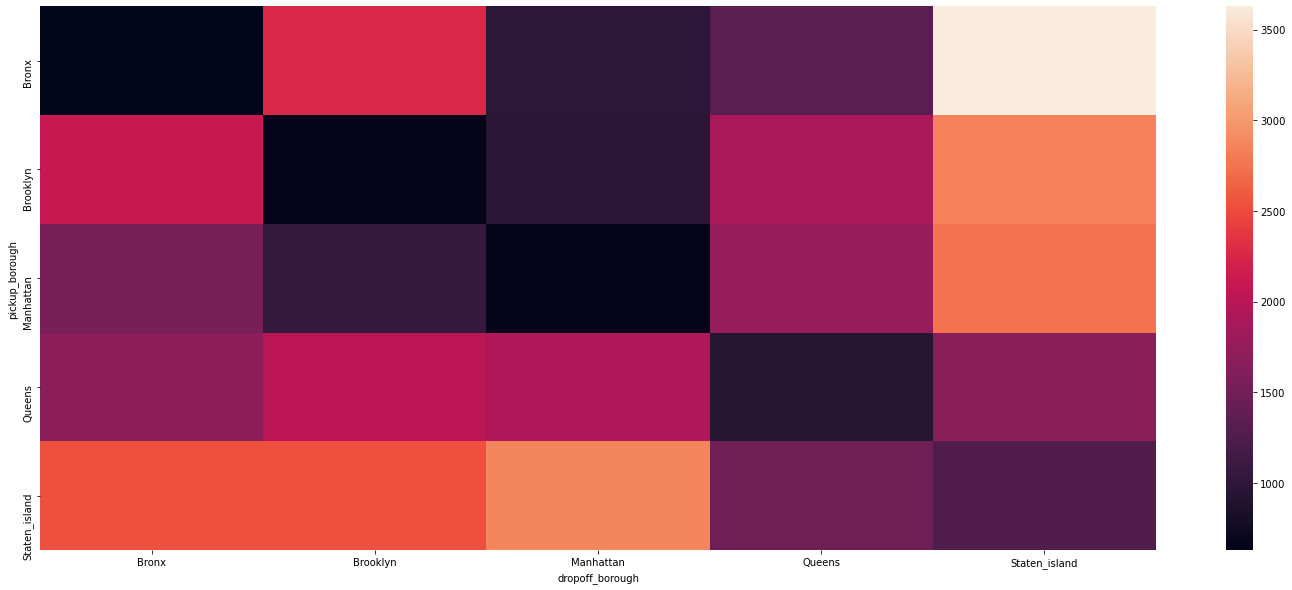

In [26]:
plt.subplots(figsize=(25, 10))
sns.heatmap(pivot_table)

Podemos concluir que la combinación de locación inicial y locación final son determinantes para predecir la duración del viaje, por lo tanto, son variables que definitivamente deben estar incluidas en el modelo de predicción.

#### Referencias
Aquí podrás encontrar los links de la documentación de las librerías que usamos durante el workshop.
* [`pandas`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html)
* [`seaborn`](https://seaborn.pydata.org/)
* [`matplotlib`](https://matplotlib.org/)
* [`plotly`](https://plotly.com/)

Adicionalmente, te recomendamos leer el libro Python Data Science Handbook de Jake VanderPlas, donde podrás encontrar muy buen contenido sobre manejo de datos a través de `numpy` y `pandas`, visualización con `matplotlib` y desarrollo de modelos de machine learning con `scikit-learn`.

**CHECK POINT #4**

Agrega tu notebook a la rama que creaste, realiza el `commit` correspondiente y realiza merge con la rama `main`.